# Recommendation System

---

1. Download dataset

In [1]:
!wget https://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip -q ml-100k.zip

--2025-06-01 18:17:51--  https://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  3.19MB/s    in 1.5s    

2025-06-01 18:17:53 (3.19 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]



In [2]:
# load ratings & movie data
import pandas as pd

ratings = pd.read_csv("ml-100k/u.data", sep='\t', header=None,
                      names=["user_id", "movie_id", "rating", "timestamp"])

movies = pd.read_csv("ml-100k/u.item", sep='|', encoding='latin-1', header=None,
                     names=["movie_id", "title", "release_date", "video_release_date", "IMDb_URL"]
                     + [f"genre_{i}" for i in range(19)])

ratings.head(), movies[["movie_id", "title"]].head()

(   user_id  movie_id  rating  timestamp
 0      196       242       3  881250949
 1      186       302       3  891717742
 2       22       377       1  878887116
 3      244        51       2  880606923
 4      166       346       1  886397596,
    movie_id              title
 0         1   Toy Story (1995)
 1         2   GoldenEye (1995)
 2         3  Four Rooms (1995)
 3         4  Get Shorty (1995)
 4         5     Copycat (1995))

In [3]:
# reviewing dataset structure
print(f"Ratings shape: {ratings.shape}")
print(f"Unique users: {ratings['user_id'].nunique()}")
print(f"Unique movies: {ratings['movie_id'].nunique()}")
ratings.info()
movies.info()

Ratings shape: (100000, 4)
Unique users: 943
Unique movies: 1682
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    100000 non-null  int64
 1   movie_id   100000 non-null  int64
 2   rating     100000 non-null  int64
 3   timestamp  100000 non-null  int64
dtypes: int64(4)
memory usage: 3.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            1682 non-null   int64  
 1   title               1682 non-null   object 
 2   release_date        1681 non-null   object 
 3   video_release_date  0 non-null      float64
 4   IMDb_URL            1679 non-null   object 
 5   genre_0             1682 non-null   int64  
 6   genre_1             1682 non-null   int64  
 7   g

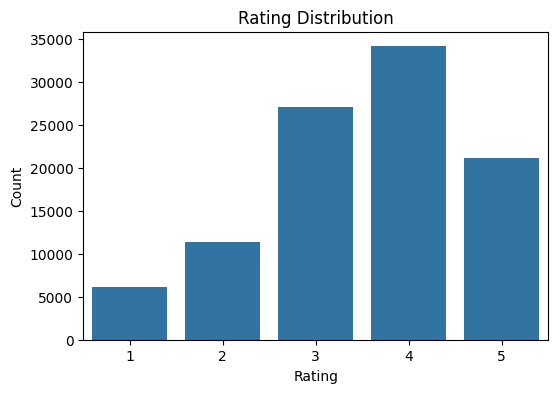

In [4]:
# rating distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings)
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

In [5]:
# user-item matrix sparsity
n_users= ratings['user_id'].nunique()
n_movies = ratings['movie_id'].nunique()
sparsity =1.0 - len(ratings) / (n_users * n_movies)

print(f"User-Tem Matrix Sparsity: {sparsity:.4f}")

User-Tem Matrix Sparsity: 0.9370


In [6]:
# most active users & most rated movies

top_users = ratings['user_id'].value_counts().head()
top_movies = ratings['movie_id'].value_counts().head()

print("Top 5 Active Users:")
print(top_users)

print("\nTop 5 Most Rated Movies:")
top_movies_ids = top_movies.index
print(movies[movies['movie_id'].isin(top_movies_ids)][["movie_id", "title"]])


Top 5 Active Users:
user_id
405    737
655    685
13     636
450    540
276    518
Name: count, dtype: int64

Top 5 Most Rated Movies:
     movie_id                      title
49         50           Star Wars (1977)
99        100               Fargo (1996)
180       181  Return of the Jedi (1983)
257       258             Contact (1997)
293       294           Liar Liar (1997)


In [7]:
avg_movies_per_user = ratings['user_id'].value_counts().mean()
print(f"Average movies rated per user: {avg_movies_per_user:.2f}")

Average movies rated per user: 106.04
